<a href="https://colab.research.google.com/github/PedroRavaglia/3D-Reaction-Diffusion/blob/master/Numeric_Data_Complete_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U openai-whisper
!python -m spacy download pt_core_news_sm
!pip install text2num
!pip install ipython-autotime
%load_ext autotime

In [ ]:
!python -m spacy download pt_core_news_md

In [3]:
import whisper
import spacy
import re
from text_to_num import text2num
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

time: 11.8 s (started: 2023-09-28 12:28:05 +00:00)


##Carregando modelo de transcrição de áudio

In [4]:
model = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:07<00:00, 66.0MiB/s]


time: 14.1 s (started: 2023-09-28 12:28:21 +00:00)


##Carregando modelo de NLP que será usado para extrair dados dos audios transcritos

In [5]:
nlp = spacy.load("pt_core_news_sm")

time: 608 ms (started: 2023-09-28 12:28:40 +00:00)


#**Funções para a extração de dados numéricos a partir de um áudio**

##Função que retorna áudio transcrito

In [6]:
def transcription(file_name, model, prompt):
  trans = model.transcribe(f'/content/drive/MyDrive/MS/Data Extraction From Audio/audios/{file_name}.mp3', language="pt", fp16=False, initial_prompt=prompt)
  return trans["text"]

time: 706 µs (started: 2023-09-28 12:28:46 +00:00)


##Função que converte para digitos alguns números que foram transcritos por extenso, facilitando a detecção de tokens numéricos pelo modelo NLP

In [7]:
def clean_trans(str):
  # convert_list = [
  #   (' zero ', '0'),
  #   (' um ', '1'),
  #   (' dois ', '2'),
  #   (' três ', '3'),
  #   (' quatro ', '4'),
  #   (' cinco ', '5'),
  #   (' seis ', '6'),
  #   (' meia ', '6'),
  #   (' sete ', '7'),
  #   (' oito ', '8'),
  #   (' nove ', '9'),
  # ]
  convert_list = [
    ('um', '1'),
    ('meia', '6'),
    ('meio', '6'),
    (',', ' '),
    ('código da instalação', 'código_da_instalação'),
    ('código de instalação', 'código_da_instalação'),
    ('código do cliente', 'código_do_cliente'),
    ('código de cliente', 'código_do_cliente'),
  ]

  for n in convert_list:
    str = str.replace(n[0], n[1])

  return str

time: 794 µs (started: 2023-09-28 12:28:47 +00:00)


##Função que recebe um token numérico e retorna a versão em digito dele

In [8]:
def token_to_digit(t):
  n = t.text.replace('.', '').replace('-', '')

  if n.isdigit():
    return n

  elif t.pos_ == "NUM":
    return str(text2num(n, "pt"))

  return ''

time: 850 µs (started: 2023-09-28 12:29:21 +00:00)


##Função que extrai dados numéricos de uma transcrição usando um modelo NLP

In [9]:
def num_data_from_trans(trans, nlp):
  data_types = ['cpf', 'telefone', 'código_da_instalação', 'código_do_cliente']
  data = {
    'cpf':                  {'data': '', 'size': 11},
    'telefone':             {'data': '', 'size': 11},
    'código_da_instalação': {'data': '', 'size': 8 },
    'código_do_cliente':    {'data': '', 'size': 10},
  }
  searching = ''

  trans_clean = clean_trans(trans)
  doc = nlp(trans_clean)

  for t in doc:
    if t.text.lower() in data_types:
      searching = t.text.lower()

    # No caso em que o token atual for numérico e a string 'searching' não
    # estiver vazia, o valor desse token é adicionado à string referente ao
    # 'searching' em 'data'
    elif (t.pos_ == 'NUM' or t.pos_ == 'X') and searching:
      data[searching]['data'] += token_to_digit(t)

      # Confere se existe um token depois do atual
      if t.i + 1 < len(doc):
        # Confere se o próximo token é numérico
        if doc[t.i + 1].pos_ != 'NUM':
          # Confere se o comprimento da string coletada até agora é menor do que
          # o comprimento completo dela
          if len(data[searching]['data']) < data[searching]['size']:
            # Caso o próximo token não seja numérico e o comprimento da string
            # coletada até agora não seja seu comprimento completo, reiniciamos
            # a string
            data[searching]['data'] = ''

          else:
            # Caso contrário, temos que a string atingiu seu comprimento completo,
            # com isso reiniciamos a string de searching
            searching = ''

  return {
    'cpf':                  data['cpf']['data'],
    'telefone':             data['telefone']['data'],
    'código_da_instalação': data['código_da_instalação']['data'],
    'código_do_cliente':    data['código_do_cliente']['data'],
  }

time: 1.44 ms (started: 2023-09-28 12:29:25 +00:00)


In [10]:
def results(data, model, prompt, nlp):
  data_types = ['cpf', 'telefone', 'código_da_instalação', 'código_do_cliente']
  file_paths = []
  transcriptions = []

  extract_data = [[], [], [], []]

  real_data = [[], [], [], []]

  correct = [[], [], [], [], []]
  total_comparison = True

  for file_path, real_nums in data:
    file_paths.append(file_path)

    trans = transcription(file_path, model, prompt)
    transcriptions.append(trans)

    nums = num_data_from_trans(trans, nlp)

    for i, data_type in enumerate(data_types):

      extract_data[i].append(nums[data_type])
      real_data[i].append(real_nums[data_type])

      compare = True if nums[data_type] == real_nums[data_type] else False
      correct[i].append(compare)
      if not compare:
        total_comparison = False

    correct[4].append(total_comparison)
    total_comparison = True

  df = pd.DataFrame({
      'file_path': file_paths,
      'transcription': transcriptions,
      'correct': correct[4],

      'detected_cpf': extract_data[0],
      'real_cpf': real_data[0],
      'correct_cpf': correct[0],

      'detected_telefone': extract_data[1],
      'real_telefone': real_data[1],
      'correct_telefone': correct[1],

      'detected_código_da_instalação': extract_data[2],
      'real_código_da_instalação': real_data[2],
      'correct_código_da_instalação': correct[2],

      'detected_código_do_cliente': extract_data[3],
      'real_código_do_cliente': real_data[3],
      'correct_código_do_cliente': correct[3],
      })

  return df

time: 1.17 ms (started: 2023-09-28 12:29:33 +00:00)


In [11]:
def get_values(df, label):
  values = df[label].value_counts()

  if False in values and True in values:
    n_corretos = values[0]
    n_errados = values[1]

  elif False not in values and True in values:
    n_corretos = values[0]
    n_errados = 0

  elif False in values and True not in values:
    n_corretos = 0
    n_errados = values[0]

  else:
    n_corretos = 0
    n_errados = 0

  return [n_corretos, n_errados]

time: 878 µs (started: 2023-09-28 12:29:37 +00:00)


In [536]:
def correct_anal(df):
  cols = [
      'correct',
      'correct_cpf',
      'correct_telefone',
      'correct_código_da_instalação',
      'correct_código_do_cliente'
    ]
  acertos = [get_values(df, col) for col in cols]
  h0 = ['Todos certos', 'Algum errado']
  h = ['Acertos', 'Erros']

  axd = plt.figure(layout="constrained", figsize=(10, 7)).subplot_mosaic(
      """
      AABC
      AADE
      GGGG
      FFFF
      FFFF
      """
  )


  axd['A'].bar(h0, acertos[0], color=['tab:orange', 'tab:blue'])
  axd['A'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['A'].set_yticks(acertos[0])
  axd['A'].set_title('Acertou todos os dados numéricos ou\n errou pelo menos um')

  axd['B'].bar(h, acertos[1], color=['tab:orange', 'tab:blue'])
  axd['B'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['B'].set_yticks(acertos[1])
  axd['B'].set_title('CPF')

  axd['C'].bar(h, acertos[2], color=['tab:orange', 'tab:blue'])
  axd['C'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['C'].set_yticks(acertos[2])
  axd['C'].set_title('Telefone')

  axd['D'].bar(h, acertos[3], color=['tab:orange', 'tab:blue'])
  axd['D'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['D'].set_yticks(acertos[3])
  axd['D'].set_title('Código da Instalação')

  axd['E'].bar(h, acertos[4], color=['tab:orange', 'tab:blue'])
  axd['E'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['E'].set_yticks(acertos[4])
  axd['E'].set_title('Código do Cliente')

  n = df.shape[0]
  acc = [round(acertos[i][0] / n, 3) for i in range(5)]
  acc_str = [f'{round(perc*100, 2)}%' for perc in acc]
  acc_media = round(sum(acc[1:]) /len(acc[1:]), 3)
  acc_media_str = f'{round(acc_media*100, 2)}%'

  h_acc = ['Todos certos', 'CPF', 'Telefone', 'CdI', 'CdC', 'Média']
  acc_plot = acc
  acc_plot.append(acc_media)

  axd['F'].bar(h_acc, acc_plot, color=['tab:blue', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:blue'])
  axd['F'].yaxis.set_major_locator(MaxNLocator(integer=True))
  axd['F'].set_yticks([0.1*i for i in range(11)])
  axd['F'].set_title('Acurácia da detecção dos dados numéricos')

  for i in range(len(acc_plot)):
    plt.text(i, acc_plot[i]-0.08, acc_plot[i], fontsize=11, ha = 'center', color='white', weight='bold')

  axd['A'].annotate(f'Total de áudios: {n}', xy=(0, 1.4), xycoords='axes fraction', ha='left', weight='bold', fontsize=16)

  axd['G'].remove()

  plt.show()

time: 3.57 ms (started: 2023-09-28 20:19:17 +00:00)


In [246]:
def update_csv(file_path, df):
  old_df = pd.read_csv('/content/drive/MyDrive/MS/Data Extraction From Audio/DB/' + file_path)

  # clean_df = pd.merge(df, old_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
  new_df = pd.concat([old_df, df], axis=0).reset_index(drop=True)
  new_df.to_csv('/content/drive/MyDrive/MS/Data Extraction From Audio/DB/' + file_path, index=False)

  return new_df

time: 919 µs (started: 2023-09-28 16:20:19 +00:00)


#**Testando a acurácia do modelo criado para detectar dados númericos a partir de áudios**

In [16]:
prompt = "e-mail arroba underline traço hifen mais gmail.com hotmail.com msbrazil.com yahoo yahoo.com uol.com alerj cpf código da instalação código do cliente"

time: 527 µs (started: 2023-09-28 12:31:05 +00:00)


In [14]:
file_paths = [
    ('CPF', {'cpf': '12345678900', 'telefone': '', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('num', {'cpf': '55517492022', 'telefone': '', 'código_da_instalação': '10748703', 'código_do_cliente': '7065332455'}),
    ('CPF_2', {'cpf': '77766694600', 'telefone': '', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('CPF_3', {'cpf': '98765432100', 'telefone': '', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('atendimento', {'cpf': '12345678900', 'telefone': '11987654321', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('atendimento_2', {'cpf': '17990183773', 'telefone': '', 'código_da_instalação': '9876543210', 'código_do_cliente': '7065302556'}),
    ('atendimento_3', {'cpf': '12049211166', 'telefone': '', 'código_da_instalação': '24681357', 'código_do_cliente': '1122334455'}),
    ('atendimento_4', {'cpf': '12566629600', 'telefone': '21982697733', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('atendimento_5', {'cpf': '15986437250', 'telefone': '21982749072', 'código_da_instalação': '24681356', 'código_do_cliente': '9876543210'}),
    ('atendimento_6', {'cpf': '36985274125', 'telefone': '', 'código_da_instalação': '24765429', 'código_do_cliente': '2469287200'}),
    ('atendimento_7', {'cpf': '21132344641', 'telefone': '21936031050', 'código_da_instalação': '56202090', 'código_do_cliente': ''}),
    ('atendimento_8', {'cpf': '', 'telefone': '', 'código_da_instalação': '90062003', 'código_do_cliente': '6790017460'}),
    ('atendimento_9', {'cpf': '89045673677', 'telefone': '21945783500', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('atendimento_10', {'cpf': '', 'telefone': '', 'código_da_instalação': '60067367', 'código_do_cliente': '0011223344'}),
]

time: 2.28 ms (started: 2023-09-28 12:30:54 +00:00)


In [17]:
df = results(file_paths, model, prompt, nlp)
display(df)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,CPF,meu cpf é 12345678900,True,12345678900,12345678900,True,,,True,,,True,,,True
1,num,olá boa tarde antes de continuar o atendiment...,True,55517492022,55517492022,True,,,True,10748703,10748703,True,7065332455,7065332455,True
2,CPF_2,para acessar a minha conta necessário cpf 777...,True,77766694600,77766694600,True,,,True,,,True,,,True
3,CPF_3,boa tarde para continuar conversa se eu poder...,True,98765432100,98765432100,True,,,True,,,True,,,True
4,atendimento,olá em nome da anel energia seja bem-vindo ao...,True,12345678900,12345678900,True,11987654321,11987654321,True,,,True,,,True
5,atendimento_2,alo estou ligando para distribuir dor de ener...,False,,17990183773,False,,,True,9876543210,9876543210,True,7065302556,7065302556,True
6,atendimento_3,alô estou ligando para distribuidora de luz t...,False,12049211166,12049211166,True,,,True,24681357,24681357,True,,1122334455,False
7,atendimento_4,ola boa noite antes de começarmos o nosso ate...,True,12566629600,12566629600,True,21982697733,21982697733,True,,,True,,,True
8,atendimento_5,boa noite estou ligando para distribuidora de...,False,15986437250,15986437250,True,,21982749072,False,204681350,24681356,False,9876543210,9876543210,True
9,atendimento_6,aloestor ligando para distribuidora de luz x ...,False,,36985274125,False,,,True,24765429,24765429,True,,2469287200,False


time: 10min 22s (started: 2023-09-28 12:31:08 +00:00)


In [19]:
df.to_csv("/content/drive/MyDrive/MS/Data Extraction From Audio/DB/num_transcription_quality.csv", index=False)

time: 1.2 s (started: 2023-09-28 12:43:11 +00:00)


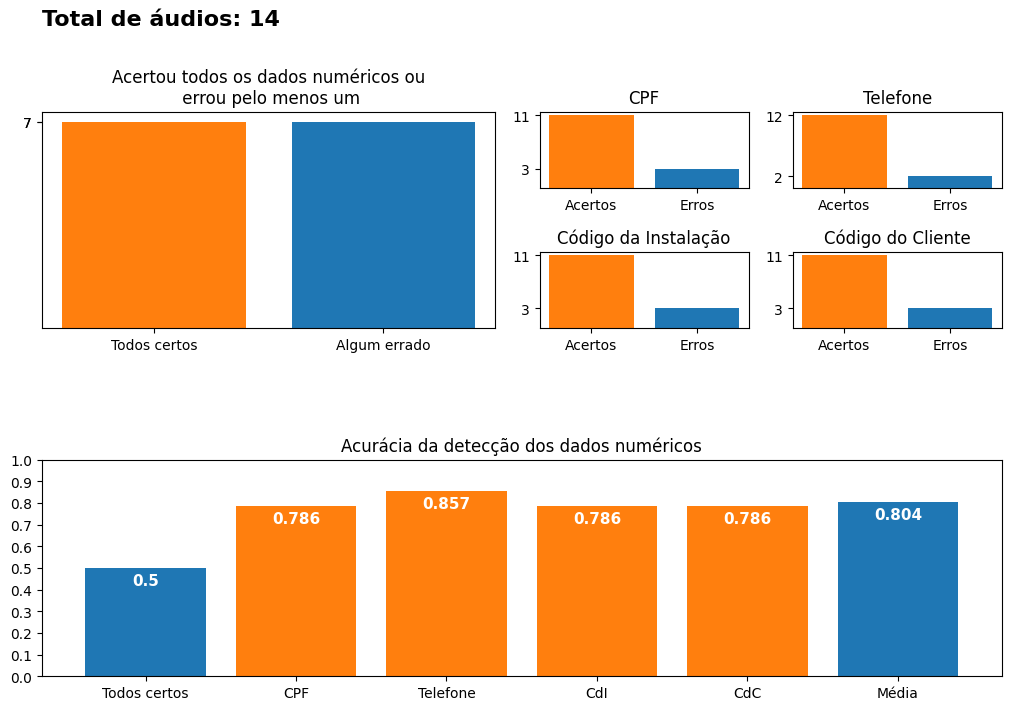

time: 871 ms (started: 2023-09-28 20:19:22 +00:00)


In [537]:
correct_anal(df)

#**Usando o modelo médio do Whisper**

In [21]:
md_model = whisper.load_model("medium")

100%|█████████████████████████████████████| 1.42G/1.42G [00:18<00:00, 82.7MiB/s]


time: 45.9 s (started: 2023-09-28 12:43:54 +00:00)


In [22]:
md_df = results(file_paths, md_model, prompt, nlp)
display(md_df)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,CPF,meu cpf é 12345678900,True,12345678900,12345678900,True,,,True,,,True,,,True
1,num,olá boa tarde antes de continuar o atendiment...,True,55517492022,55517492022,True,,,True,10748703,10748703,True,7065332455,7065332455,True
2,CPF_2,para acessar a minha conta necessário o cpf 7...,True,77766694600,77766694600,True,,,True,,,True,,,True
3,CPF_3,boa tarde para continuar a conversa você pode...,True,98765432100,98765432100,True,,,True,,,True,,,True
4,atendimento,olá em nome da neonergia seja bem-vindo ao no...,True,12345678900,12345678900,True,11987654321,11987654321,True,,,True,,,True
5,atendimento_2,alô estou ligando para distribuidor de energi...,True,17990183773,17990183773,True,,,True,9876543210,9876543210,True,7065302556,7065302556,True
6,atendimento_3,alô estou ligando para distribuidor de luz te...,True,12049211166,12049211166,True,,,True,24681357,24681357,True,1122334455,1122334455,True
7,atendimento_4,olá boa noite antes de começarmos o nosso ate...,True,12566629600,12566629600,True,21982697733,21982697733,True,,,True,,,True
8,atendimento_5,boa noite estou ligando para distribuidoria d...,False,15986437250,15986437250,True,21982749072,21982749072,True,24681356,24681356,True,98765432110,9876543210,False
9,atendimento_6,alô estou ligando para o distribuidor de luz ...,True,36985274125,36985274125,True,,,True,24765429,24765429,True,2469287200,2469287200,True


time: 25min 8s (started: 2023-09-28 12:44:43 +00:00)


In [ ]:
md_df.to_csv("/content/drive/MyDrive/MS/Data Extraction From Audio/DB/md_num_transcription_quality.csv", index=False)

time: 16.2 ms (started: 2023-09-27 20:34:39 +00:00)


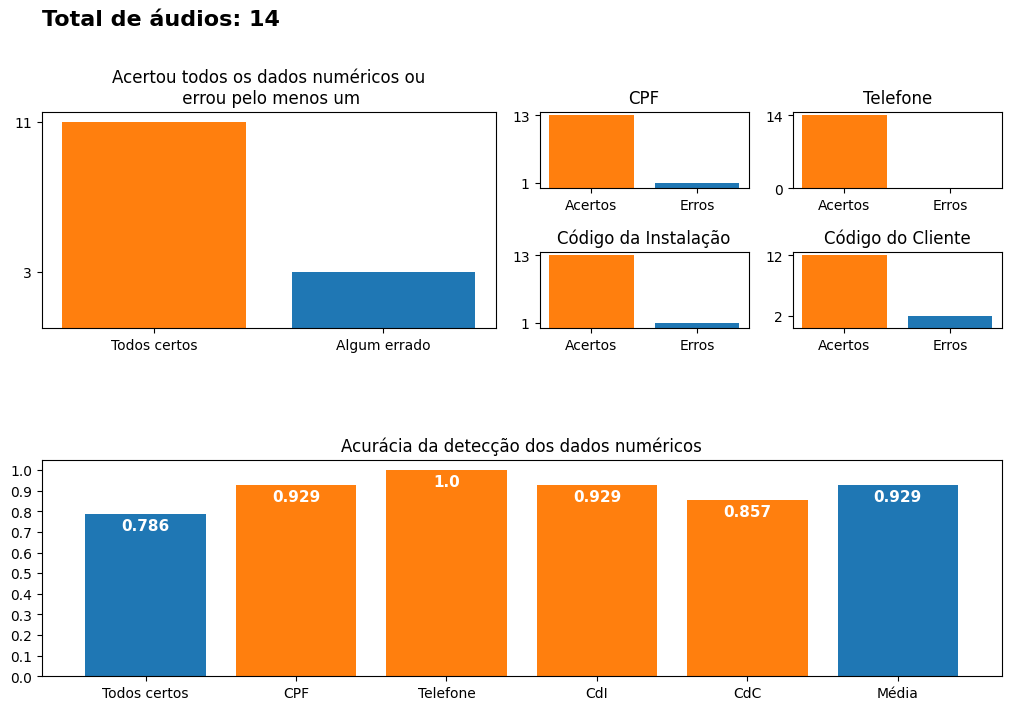

time: 2.27 s (started: 2023-09-28 20:19:50 +00:00)


In [538]:
correct_anal(md_df)

#**Outros testes com o modelo small**

In [ ]:
file_paths_2 = [
    ('atendimento_3', {'cpf': '12049211166', 'telefone': '', 'código_da_instalação': '24681357', 'código_do_cliente': '1122334455'}),
    ('atendimento_4', {'cpf': '12566629600', 'telefone': '21982697733', 'código_da_instalação': '', 'código_do_cliente': ''}),
]

time: 776 µs (started: 2023-09-27 13:11:36 +00:00)


In [ ]:
df_2 = results(file_paths_2, model, prompt, nlp)
display(df_2)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_3,alô estou ligando para distribuidora de luz t...,False,12049211166,12049211166,True,,,True,24681357,24681357,True,,1122334455,False
1,atendimento_4,ola boa noite antes de começarmos o nosso ate...,True,12566629600,12566629600,True,21982697733,21982697733,True,,,True,,,True


time: 1min 42s (started: 2023-09-27 13:11:48 +00:00)


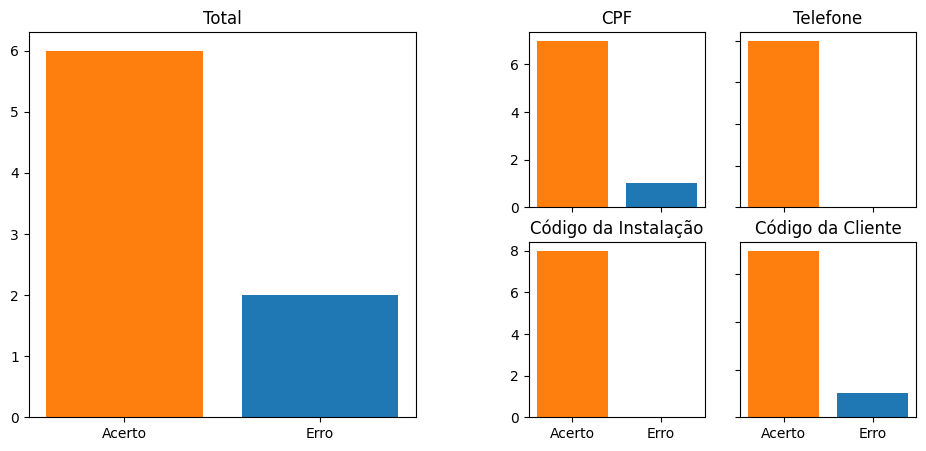


Total: 8
Acertos: 6
Erros: 2
Acurácia: 0.75
time: 730 ms (started: 2023-09-27 17:09:54 +00:00)


In [ ]:
correct_anal(df_2)

In [ ]:
file_paths_3 = [
    ('atendimento_5', {'cpf': '15986437250', 'telefone': '21982749072', 'código_da_instalação': '24681356', 'código_do_cliente': '9876543210'}),
    ('atendimento_6', {'cpf': '36985274125', 'telefone': '', 'código_da_instalação': '24765429', 'código_do_cliente': '2469287200'}),
]

time: 946 µs (started: 2023-09-27 19:39:50 +00:00)


In [ ]:
df_3 = results(file_paths_3, model, prompt, nlp)
display(df_3)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_5,boa noite estou ligando para distribuidora de...,False,15986437250,15986437250,True,,21982749072,False,204681350,24681356,False,9876543210,9876543210,True
1,atendimento_6,aloestor ligando para distribuidora de luz x ...,False,,36985274125,False,,,True,24765429,24765429,True,,2469287200,False


time: 2min 17s (started: 2023-09-27 19:39:52 +00:00)


In [ ]:
file_paths_4 = [
    ('atendimento_7', {'cpf': '21132344641', 'telefone': '21936031050', 'código_da_instalação': '56202090', 'código_do_cliente': ''}),
    ('atendimento_8', {'cpf': '', 'telefone': '', 'código_da_instalação': '90062003', 'código_do_cliente': '6790017460'}),
]

time: 897 µs (started: 2023-09-27 20:02:28 +00:00)


In [ ]:
df_4 = results(file_paths_4, model, prompt, nlp)
display(df_4)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_7,bom a noite como medida protocolar você poder...,True,21132344641,21132344641,True,21936031050,21936031050,True,56202090,56202090,True,,,True
1,atendimento_8,boa noite antes do atendimento com o mediano ...,False,,,True,,,True,960262003,90062003,False,670917460,6790017460,False


time: 1min 2s (started: 2023-09-27 20:08:03 +00:00)


In [ ]:
file_paths_5 = [
    ('atendimento_9', {'cpf': '89045673677', 'telefone': '21945783500', 'código_da_instalação': '', 'código_do_cliente': ''}),
    ('atendimento_10', {'cpf': '', 'telefone': '', 'código_da_instalação': '60067367', 'código_do_cliente': '0011223344'}),
]

time: 699 µs (started: 2023-09-27 20:42:51 +00:00)


In [ ]:
df_5 = results(file_paths_5, model, prompt, nlp)
display(df_5)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_9,boa noite antes de iniciar o seu atendimento ...,False,,89045673677,False,,21945783500,False,,,True,,,True
1,atendimento_10,como medida protocolar se poderem nos informa...,False,,,True,,,True,600673673,60067367,False,0011223344,0011223344,True


time: 1min 50s (started: 2023-09-27 20:45:56 +00:00)


#**Outros teste com o modelo medium**

In [ ]:
md_df_2 = results(file_paths_2, md_model, prompt, nlp)
display(md_df_2)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_3,alô estou ligando para distribuidor de luz te...,False,12049211166,12049211166,True,,,True,24681357,24681357,True,,1122334455,False
1,atendimento_4,olá boa noite antes de começarmos o nosso ate...,True,12566629600,12566629600,True,21982697733,21982697733,True,,,True,,,True


time: 4min 38s (started: 2023-09-27 13:13:49 +00:00)


In [ ]:
md_df_3 = results(file_paths_3, md_model, prompt, nlp)
display(md_df_3)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_5,boa noite estou ligando para distribuidoria d...,False,15986437250,15986437250,True,21982749072,21982749072,True,24681356,24681356,True,98765432110,9876543210,False
1,atendimento_6,alô estou ligando para o distribuidor de luz ...,True,36985274125,36985274125,True,,,True,24765429,24765429,True,2469287200,2469287200,True


time: 7min 8s (started: 2023-09-27 19:20:01 +00:00)


In [ ]:
md_df_4 = results(file_paths_4, md_model, prompt, nlp)
display(md_df_4)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_7,bom noite como medida protocolar você poderia...,False,,21132344641,False,21936031050,21936031050,True,56202090,56202090,True,,,True
1,atendimento_8,"boa noite, antes do atendimento como medida p...",False,,,True,,,True,,90062003,False,67917460,6790017460,False


time: 3min 7s (started: 2023-09-27 20:12:01 +00:00)


In [ ]:
md_df_4['transcription'][1]

' boa noite, antes do atendimento como medida protocolar você poderia nos informar alguns dados pessoais seus? claro, muito bem, você poderia nos informar primeiro seu código da instalação? sim, meu código da instalação é 962.003 agora você poderia nos informar seu código do cliente? claro, meu código do cliente é 67.917.460'

time: 5.06 ms (started: 2023-09-27 20:18:14 +00:00)


In [ ]:
md_df_5 = results(file_paths_5, md_model, prompt, nlp)
display(md_df_5)

,file_path,transcription,correct,detected_cpf,real_cpf,correct_cpf,detected_telefone,real_telefone,correct_telefone,detected_código_da_instalação,real_código_da_instalação,correct_código_da_instalação,detected_código_do_cliente,real_código_do_cliente,correct_código_do_cliente
0,atendimento_9,boa noite antes de iniciar meu seu atendiment...,True,89045673677,89045673677,True,21945783500,21945783500,True,,,True,,,True
1,atendimento_10,como medida protocolar você poderia nos infor...,True,,,True,,,True,60067367,60067367,True,0011223344,0011223344,True


time: 2min 59s (started: 2023-09-27 20:48:35 +00:00)
